In [1]:
import pandas as pd
import time


from scipy.stats import uniform, randint

#visualizing data
import seaborn as sns  
import matplotlib.pyplot as plt 

#Model Training
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV


#Evaluation metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



In [2]:
df_customers  = pd.read_csv('data/ACME-HappinessSurvey2020.csv')

In [3]:
df_customers.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


- X1 = Order on Time
- X2 = Contents as Expected
- X3 = Ordered Everything I wanted to order
- X4 = I paid a good price for my order
- X5 = I am satisfied with my courier
- X6 = the app makes ordering easy for me


Goal: Predict Customer Happiness

In [4]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


In [5]:
df_customers.describe()

,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [6]:
df_customers.describe().T

,count,mean,std,min,25%,50%,75%,max
Y,126.0,0.547619,0.499714,0.0,0.0,1.0,1.0,1.0
X1,126.0,4.333333,0.800000,1.0,4.0,5.0,5.0,5.0
X2,126.0,2.531746,1.114892,1.0,2.0,3.0,3.0,5.0
X3,126.0,3.309524,1.023440,1.0,3.0,3.0,4.0,5.0
X4,126.0,3.746032,0.875776,1.0,3.0,4.0,4.0,5.0
X5,126.0,3.650794,1.147641,1.0,3.0,4.0,4.0,5.0
X6,126.0,4.253968,0.809311,1.0,4.0,4.0,5.0,5.0


X1 (Order comes on time) and X6 (App makes it easy to order) have the highest means for the attributes. X2 (Contents as Expected) have the lowest.

<AxesSubplot: >

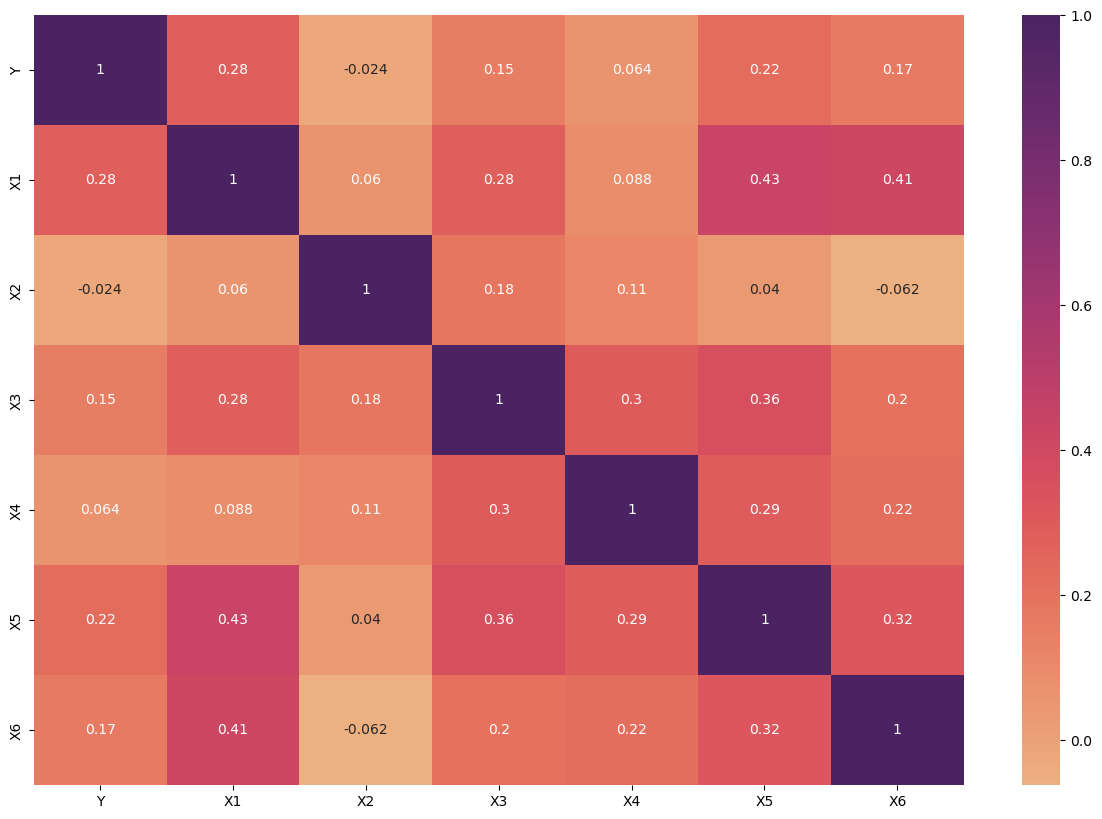

In [7]:
fig, ax = plt.subplots(figsize=(15,10))  
corr = df_customers.corr()
sns.heatmap(corr, annot=True, cmap="flare")

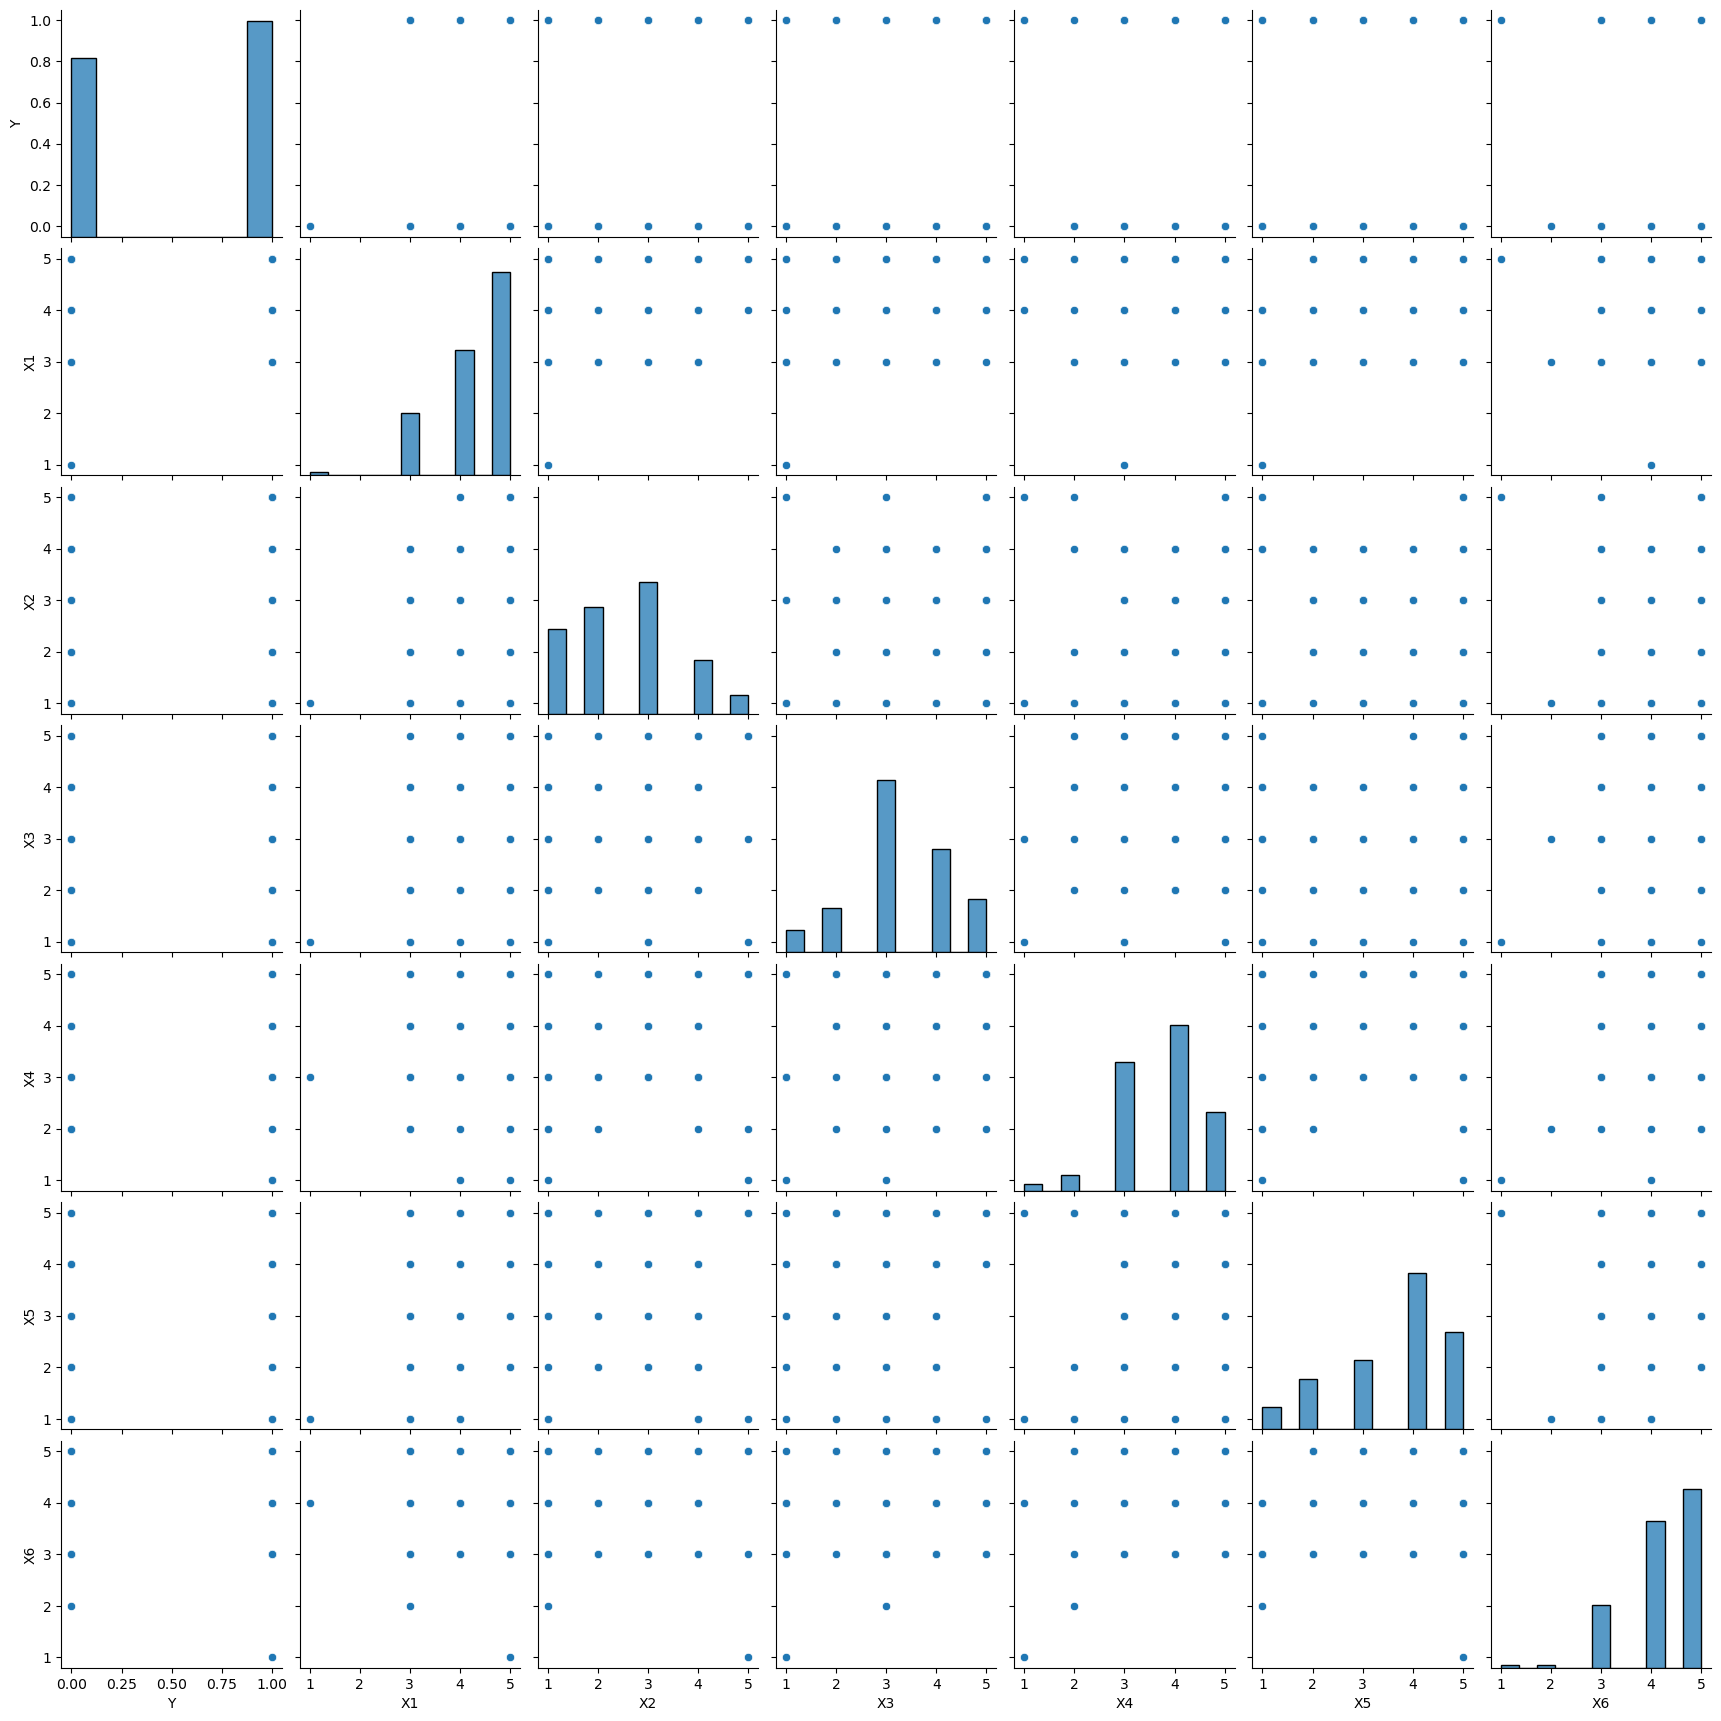

In [8]:
sns.pairplot(df_customers)

Check missing values

In [9]:
df_customers.isnull().sum()

Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
dtype: int64

# Feature Engineering

In [10]:
#separate the Target and Features
target = df_customers['Y'] 
features = df_customers.drop(['Y'], axis=1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state= 32) 

In [12]:
print(features.shape)
print(target.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)



(126, 6)
(126,)
(100, 6)
(26, 6)
(100,)
(26,)


In [13]:
print(y_train.value_counts())
print(y_test.value_counts())

1    54
0    46
Name: Y, dtype: int64
1    15
0    11
Name: Y, dtype: int64


The Training and Testing set seems balanced

# Model Development

In [14]:
import xgboost as xgb

In [15]:
def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20},cmap="Blues");

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

In [16]:
#simply print the best models and its parameters
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [22]:
def xgb_classifier(X_train, X_test, y_train, y_test, cv_folds = 5, early_stopping_rounds=50):


   params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
    }
#    param_test = {
#    "colsample_bytree": list(uniform(0.7, 0.3)),
#     "gamma": list(uniform(0, 0.5)),
#     "learning_rate": list(uniform(0.03, 0.3)), # default 0.1 
#     "max_depth": list(randint(2, 6)), # default 3
#     "n_estimators": list(randint(100, 150)), # default 100
#     "subsample": list(uniform(0.6, 0.4)),
#     'gamma':[i/10.0 for i in range(0,5)],
# }

   gsearch = RandomizedSearchCV(estimator = xgb.XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
   min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
   objective= 'binary:logistic', nthread=2,seed=27), 
   param_distributions= params, scoring='accuracy',n_jobs=4, cv=10)

    # alg = xgb.XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
    #                     min_child_weight=3, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
    #                     objective='binary:logistic', nthread=4, seed=32)

  

    # search = RandomizedSearchCV(alg, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

    
    # if use_cv:
    #     print('Start Feeding in the data:')
    #     xgb_params = alg.get_xgb_params()
    #     xgb_train = xgb.DMatrix(X_train.values,label=y_train.values)
    #     cv_result = xgb.cv(xgb_params,xgb_train,num_boost_round=alg.get_params()['n_estimators'],nfold=cv_folds,early_stopping_rounds=early_stopping_rounds)
    #     alg.set_params(n_estimators=cv_result.shape[0])

   print('Training start:')
   gsearch.fit(X_train,y_train)

   print("Start Predicting")
   predictions = gsearch.predict(X_test)
   pred_proba = gsearch.predict_proba(X_test)[:, 1]

   print(' Accuracy score: ', accuracy_score(y_test,predictions))

   conf_matrix(y_test,predictions)

   #feat_imp = gsearch.feature_importances_
   #feat = X_train.columns.tolist()
   # clf.best_estimator_.booster().get_fscore()
   #res_df = pd.DataFrame({'Features': feat, 'Importance': feat_imp}).sort_values(by='Importance', ascending=False)
   #res_df.plot('Features', 'Importance', kind='bar', title='Feature Importances')
   sorted_idx = gsearch.best_estimator_.feature_importances_.argsort()
   plt.figure(figsize=(10,10))
   plt.barh(X_train.columns[sorted_idx], gsearch.best_estimator_.feature_importances_[sorted_idx])
   plt.xlabel("Xgboost Feature Importance")
   plt.ylabel('Feature Importance Score')
   plt.show()
   #  print(res_df)
   #  print(res_df["Features"].tolist())

    


Training start:
Start Predicting
 Accuracy score:  0.46153846153846156


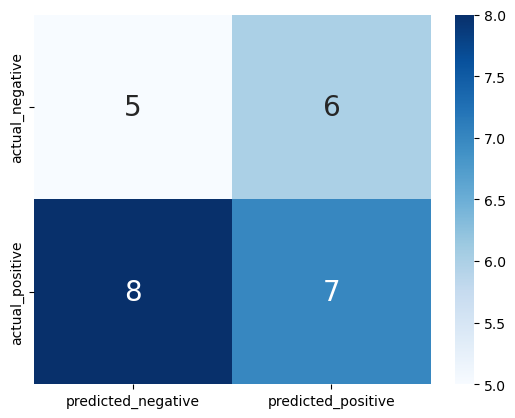

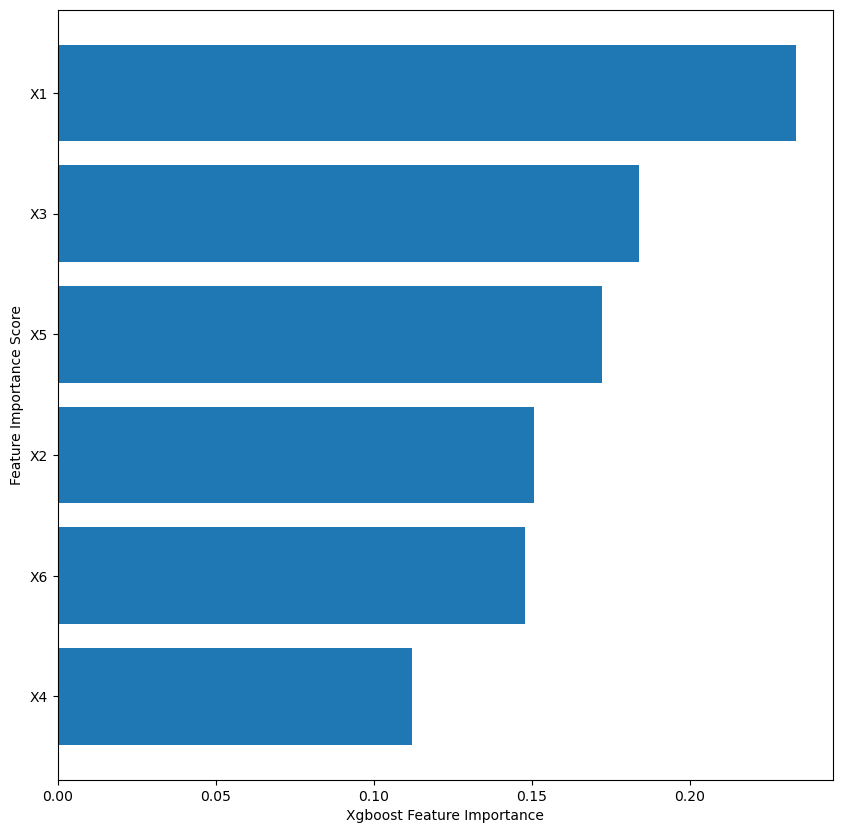

Total Time is:  0.05362991094589233


In [23]:
start = time.time()
xgb_classifier(X_train, X_test, y_train, y_test,)
print("Total Time is: ", (time.time() - start)/60)